In [1]:
import json
from collections import Counter
import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
fname = "/Users/jonathanraiman/Desktop/datasets/category_graph.json"

In [3]:
with open(fname, "rt") as f:
    graph = json.load(f)

### Clean broken, disconnected elements, from graph:

In [4]:
bad_keys = []
for key in graph.keys():
    if "[[" in key or "]]" in key:
        bad_keys.append(key)
for key in bad_keys:
    del graph[key]

for el in graph.keys():
    kids = []
    for child in graph[el]:
        if "[[" in child or "]]" in child:
            continue
        if child.lower().startswith("category:"):
            if "Category:" + child.split(":",1)[1] in graph:
                kids.append("Category:" + child.split(":",1)[1])
        else:
            kids.append(child)
    graph[el] = kids

### Special Nodes

In [173]:
cats = set()
articles = set()
for key, value in graph.items():
    if key.startswith("Category:"):
        cats.add(key.replace("Category:", ""))
    for child in value:
        if not child.startswith("Category:"):
            articles.add(child)

In [174]:
fixed_points = cats & articles
blacklist = [" in ", " District", " County"]
def in_blacklist(art, bl):
    for el in bl:
        if el in art:
            return True
    return False
non_date_fixed_points = set([art for art in fixed_points if not in_blacklist(art, blacklist)])

In [8]:
inverse_graph = {}
for key in graph.keys():
    for child in graph[key]:
        if child in inverse_graph:
            inverse_graph[child].append(key)
        else:
            inverse_graph[child] = [key]

Can find the root of wikipedia by looking at [Category:Main topic classifications](https://en.wikipedia.org/wiki/Category:Main_topic_classifications) online and finding the parent for this category. Going up this leads to **Category:Articles**, which has **Category:Contents** as parent. **Category:Contents** has no parent, and is the most meta of all articles.

In [49]:
root = "Category:Contents"

In [9]:
fname_inverted = "/Users/jonathanraiman/Desktop/datasets/category_graph.inverted.json"

In [10]:
with open(fname_inverted, "wt") as f:
    json.dump(inverse_graph, f)

### Upward edges

In [51]:
from collections import deque
def get_node_depth(root, graph):
    visited_nodes = set()
    node_queue    = deque()
    depth         = {root: 0}
    node_queue.appendleft(root)
    visited_nodes.add(root)
    
    while len(node_queue) > 0:
        node = node_queue.pop()
        if node in graph:
            for child in graph[node]:
                if child not in visited_nodes:
                    node_queue.appendleft(child)
                    visited_nodes.add(child)
                    depth[child] = depth[node] + 1
    return depth

In [50]:
depth = get_node_depth(root, graph)

Export ontology to format of the form:
```
root -> child
child -> subchild
         grandchild
```
for easy serialization

In [131]:
from collections import deque
import gzip
import numpy as np
def save_graph_from_root(root, graph, outpath, connector="->", max_log1p_degree=7):
    global inverse_graph
    save_nodes = set()
    node_queue = deque()
    node_queue.appendleft(root)
    save_nodes.add(root)
    
    def acceptable_node(node):
        return (
            not node.startswith("Category:")
            or node in graph) and not node.startswith("Wikipedia:")
    
    with gzip.open(outpath, "wt") as fout:
        while len(node_queue) > 0:
            node = node_queue.pop()
            first = True
            if node in graph:
                if np.log1p(len(graph[node])) <= max_log1p_degree:
                    for child in graph[node]:
                        if acceptable_node(child):
                            if first:
                                fout.write("%s%s%s\n" % (node, connector, child))
                            else:
                                fout.write("%s\n" % (child,))
                            first = False
                            if child not in save_nodes:
                                node_queue.appendleft(child)
                                save_nodes.add(child)

In [132]:
save_graph_from_root(root, graph,
                     "/Users/jonathanraiman/Desktop/datasets/ontology.txt.gz",
                    max_log1p_degree = 7)

In [119]:
degrees = [(len(graph[node]), node) for node in graph.keys()]

In [127]:
np.expm1(7)

1095.6331584284585

Visualize distributions of degrees. Most categories have between 3 and 55 children, however there exits outliers. If we perform a cutoff $D_{\mathrm{max}}$ with $\mathrm{log}( 1 +  D_{\mathrm{max}}) = 7$

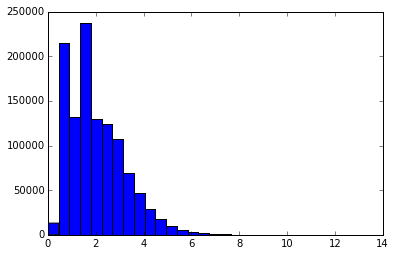

In [118]:
plt.hist(np.log1p(degrees), bins = 30);

Edges going up are parts of cycles. Let's detect them:

In [67]:
def get_upward_edges(depthmap, linking):
    upward_connections = set()
    total = 0
    for key in linking.keys():
        for child in linking[key]:
            # if child is higher up in the tree
            # then this is an upward connection
            if key in depthmap:
                if child.startswith("Category:"):
                    if depthmap[key] < depthmap[child]:
                        upward_connections.add((key, child))
                    total += 1
    return (upward_connections, total)

In [164]:
def get_connected_articles(roots, linking):
    connected_articles = set()
    visited = set()
    to_visit = list(roots)
    while len(to_visit) > 0:
        root = to_visit.pop()
        visited.add(root)
        for child in linking.get("Category:"+root,[]):
            if child.startswith("Category:"):
                if child[9:] not in visited:
                    to_visit.append(child[9:])
            else:
                connected_articles.add(child)
    return connected_articles

In [165]:
connected_arts = get_connected_articles(non_date_fixed_points, graph)

In [166]:
len(connected_arts)

4946350

In [167]:
len(articlescles)

5292971